# Thư viện

In [61]:
!pip install -q flwr[simulation]  pandas matplotlib scikit-learn torch

In [62]:
from collections import OrderedDict
from typing import List, Tuple
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import pickle

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr.server.client_proxy import ClientProxy
from flwr.common import Parameters, Scalar, FitRes, parameters_to_ndarrays
from typing import Optional, Union

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")


Training on cpu
Flower 1.13.0 / PyTorch 2.5.1


In [63]:
# Cấu hình thiết bị (CUDA hoặc CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset

In [64]:
# Đường dẫn đến tập dữ liệu
DATA_PATH = r"..\..\data\SMSSpamCollection"

# Đọc dữ liệu
data = pd.read_csv(DATA_PATH, sep='\t', header=None, names=["label", "text"])

# Chuyển đổi nhãn 'ham' và 'spam' thành 0 và 1
data["label"] = data["label"].map({"ham": 0, "spam": 1})


In [65]:
BATCH_SIZE = 16
NUM_CLIENTS = 10

## Xử lý dữ liệu

### Data Poisoning Attack

**Label Flipping**:
   - Tráo nhãn (label) của 90% dữ liệu (từ ham sang spam hoặc ngược lại).

In [66]:
class SMSDataset(Dataset):
    def __init__(self, texts, labels, vectorizer):
        self.texts = texts
        self.labels = labels
        self.vectorizer = vectorizer

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text_vector = self.vectorizer.transform([self.texts[idx]]).toarray().squeeze()
        label = self.labels[idx]
        return torch.tensor(text_vector, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


def load_datasets(partition_id: int):
    print(f"Loading dataset for partition ID: {partition_id}")

    # Load raw data
    data = pd.read_csv(DATA_PATH, sep="\t", header=None, names=["label", "text"])
    data["label"] = data["label"].map({"ham": 0, "spam": 1})

    # Vectorize text data
    vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
    vectorizer.fit(data["text"])

    # Shuffle data and reset index
    data = data.sample(frac=1, random_state=42).reset_index(drop=True)

    # Split into NUM_CLIENTS partitions
    indices = np.arange(len(data))
    split_indices = np.array_split(indices, NUM_CLIENTS)
    partition_indices = split_indices[partition_id]
    partition_data = data.iloc[partition_indices]

    # Poisoning attack (only flip labels)
    if partition_id in [1, 3, 5]:
        print("Client 1,3,5 is applying poisoning attack.")

        # Poison 90% of the data
        num_poisoned = int(0.9 * len(partition_data))  
        poisoned_indices = np.random.choice(len(partition_data), num_poisoned, replace=False)

        # Adjust poisoned indices based on the partitioning (shuffled indices)
        poisoned_indices = partition_indices[poisoned_indices]

        # Flip labels
        partition_data.loc[poisoned_indices, "label"] = partition_data.loc[poisoned_indices, "label"].apply(lambda x: 1 - x)

    # Train/val split
    train_data, val_data = train_test_split(partition_data, test_size=0.1, random_state=42)
    train_dataset = SMSDataset(train_data["text"].tolist(), train_data["label"].tolist(), vectorizer)
    val_dataset = SMSDataset(val_data["text"].tolist(), val_data["label"].tolist(), vectorizer)

    # Dataloaders
    trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    # Test set 
    if partition_id in [1, 3, 5]:
        test_data = partition_data  
    else:
        test_data = data.iloc[split_indices[-1]]  

    test_dataset = SMSDataset(test_data["text"].tolist(), test_data["label"].tolist(), vectorizer)
    testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    print(f"Partition {partition_id}: Train {len(train_data)}, Val {len(val_data)}, Test {len(test_data)}")
    return trainloader, valloader, testloader


In [67]:
data.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


# Train model

In [68]:
class Net(nn.Module):
    def __init__(self, input_dim: int):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # Fully connected layer
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)  # 2 output classes (ham, spam)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [69]:
# Lấy trainloader từ partition đầu tiên
trainloader, valloader, testloader = load_datasets(partition_id=0)

# Số chiều của đầu vào từ vectorizer
input_dim = 5000  # (đã được đặt trong load_datasets max_features=5000)

# Khởi tạo mô hình
net = Net(input_dim).to(DEVICE)
print(net)


Loading dataset for partition ID: 0
Partition 0: Train 502, Val 56, Test 557
Net(
  (fc1): Linear(in_features=5000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)


In [70]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        correct, total = 0, 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (torch.max(outputs, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader)
        epoch_acc = correct / total
        if verbose:
            print(f"Train loss {epoch_loss}, Accuracy {epoch_acc}")

def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = net(inputs)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader)
    accuracy = correct / total
    return loss, accuracy


# Federated Learning

In [71]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

In [72]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [73]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""

    input_dim = 5000  # (đã được đặt trong load_datasets max_features=5000)

    # Khởi tạo mô hình
    net = Net(input_dim).to(DEVICE)



    partition_id = context.node_config["partition-id"]
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)

    return FlowerClient(net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [74]:
def weighted_average(metrics: List[Tuple[int, dict]]) -> dict:
    """
    Compute weighted average for metrics.
    
    Args:
        metrics: List of tuples (num_examples, metrics_dict).
    
    Returns:
        dict: Aggregated metrics with weighted averages.
    """
    # Ensure there are metrics to aggregate
    if not metrics:
        return {}

    # Initialize storage for weighted sums
    weighted_sums = {}
    total_examples = 0

    for num_examples, metric_dict in metrics:
        total_examples += num_examples
        for key, value in metric_dict.items():
            if key not in weighted_sums:
                weighted_sums[key] = 0
            weighted_sums[key] += num_examples * value

    # Compute weighted averages
    aggregated_metrics = {
        key: weighted_sums[key] / total_examples for key in weighted_sums
    }
    return aggregated_metrics


In [75]:
# Custom SaveModelStrategy implementation
class SaveModelStrategy(FedAvg):
    def aggregate_fit(
        self,
        server_round: int,
        results: list[tuple[ClientProxy, FitRes]],
        failures: list[Union[tuple[ClientProxy, FitRes], BaseException]],
    ) -> tuple[Optional[Parameters], dict[str, Scalar]]:

        # Call aggregate_fit from the base class (FedAvg)
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(
            server_round, results, failures
        )

        if aggregated_parameters is not None:
            # Convert `Parameters` to `list[np.ndarray]`
            aggregated_ndarrays = parameters_to_ndarrays(aggregated_parameters)

            # Save aggregated weights for each round
            print(f"Saving round {server_round} aggregated weights...")
            np.savez(f"round-{server_round}-weights.npz", *aggregated_ndarrays)

            # Save the final model at the end of training
            if server_round == 5:
                with open("DPA_model.pkl", "wb") as f:
                    pickle.dump(aggregated_ndarrays, f)
                print("Final model saved as 'DPA_model.pkl'")
                # Lưu dưới dạng PyTorch
                torch.save(aggregated_ndarrays, "DPA_model.pth")
                print("Final model saved as 'DPA_model.pth'")

        return aggregated_parameters, aggregated_metrics

In [76]:

# Define the server function
def server_fn(context: Context) -> ServerAppComponents:
    # Use the custom SaveModelStrategy
    strategy = SaveModelStrategy(
        fraction_fit=1.0,
        fraction_evaluate=0.5,
        min_fit_clients=10,
        min_evaluate_clients=5,
        min_available_clients=10,
        fit_metrics_aggregation_fn=weighted_average,
        evaluate_metrics_aggregation_fn=weighted_average,
    )

    # Configure the server for 5 rounds of training
    config = ServerConfig(num_rounds=5)

    return ServerAppComponents(strategy=strategy, config=config)


# Create a new server instance with the SaveModelStrategy
server = ServerApp(server_fn=server_fn)

In [77]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
if DEVICE.type == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}
    # Refer to our Flower framework documentation for more details about Flower simulations
    # and how to set up the `backend_config`

In [78]:
import os

# Disable oneDNN custom operations to avoid floating-point round-off errors
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Import TensorFlow and other required libraries
import tensorflow as tf

# Initialize TensorFlow
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.18.0


In [79]:
# Run simulation
history = run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
    verbose_logging=True
)



DEBUG 2024-12-01 18:44:07,889:     Asyncio event loop already running.
DEBUG 2024-12-01 18:44:07,891:     Logger propagate set to False
DEBUG 2024-12-01 18:44:08,136:     Pre-registering run with id 1952790392414414043
DEBUG 2024-12-01 18:44:08,138:     Using InMemoryState
DEBUG 2024-12-01 18:44:08,138:     Using InMemoryState
INFO 2024-12-01 18:44:08,140:      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
DEBUG 2024-12-01 18:44:08,142:     Buffer time delay: 5s
INFO 2024-12-01 18:44:08,143:      
INFO 2024-12-01 18:44:08,144:      [INIT]
INFO 2024-12-01 18:44:08,145:      Requesting initial parameters from one random client
DEBUG 2024-12-01 18:44:13,153:     Using InMemoryState
DEBUG 2024-12-01 18:44:13,154:     Registered 10 nodes
DEBUG 2024-12-01 18:44:13,155:     Supported backends: ['ray']
DEBUG 2024-12-01 18:44:13,155:     Initialising: RayBackend
DEBUG 2024-12-01 18:44:13,156:     Backend config: {'client_resources': {'num_cpus': 1, 'num_gpus': 0.0}, 'init_ar

(ClientAppActor pid=34552) Loading dataset for partition ID: 9


INFO 2024-12-01 18:44:48,179:      Received initial parameters from one random client
INFO 2024-12-01 18:44:48,180:      Starting evaluation of initial global parameters
INFO 2024-12-01 18:44:48,181:      Evaluation returned no results (`None`)
INFO 2024-12-01 18:44:48,181:      
INFO 2024-12-01 18:44:48,182:      [ROUND 1]
INFO 2024-12-01 18:44:48,182:      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=34552) Partition 9: Train 501, Val 56, Test 557
(ClientAppActor pid=34552) Loading dataset for partition ID: 0
(ClientAppActor pid=34552) Partition 0: Train 502, Val 56, Test 557
(ClientAppActor pid=21196) Loading dataset for partition ID: 4
(ClientAppActor pid=9500) Loading dataset for partition ID: 1
(ClientAppActor pid=21196) Partition 4: Train 501, Val 56, Test 557
(ClientAppActor pid=9500) Client 1,3,5 is applying poisoning attack.


INFO 2024-12-01 18:45:05,452:      aggregate_fit: received 10 results and 0 failures
INFO 2024-12-01 18:45:05,511:      configure_evaluate: strategy sampled 5 clients (out of 10)


Saving round 1 aggregated weights...
(ClientAppActor pid=35816) Loading dataset for partition ID: 5 [repeated 8x across cluster]
(ClientAppActor pid=33468) Partition 7: Train 501, Val 56, Test 557 [repeated 8x across cluster]
(ClientAppActor pid=26788) Client 1,3,5 is applying poisoning attack. [repeated 2x across cluster]


INFO 2024-12-01 18:45:06,118:      aggregate_evaluate: received 5 results and 0 failures
INFO 2024-12-01 18:45:06,120:      
INFO 2024-12-01 18:45:06,120:      [ROUND 2]
INFO 2024-12-01 18:45:06,120:      configure_fit: strategy sampled 10 clients (out of 10)
INFO 2024-12-01 18:45:08,952:      aggregate_fit: received 10 results and 0 failures
INFO 2024-12-01 18:45:08,982:      configure_evaluate: strategy sampled 5 clients (out of 10)


Saving round 2 aggregated weights...


INFO 2024-12-01 18:45:09,372:      aggregate_evaluate: received 5 results and 0 failures
INFO 2024-12-01 18:45:09,373:      
INFO 2024-12-01 18:45:09,373:      [ROUND 3]
INFO 2024-12-01 18:45:09,375:      configure_fit: strategy sampled 10 clients (out of 10)
INFO 2024-12-01 18:45:12,229:      aggregate_fit: received 10 results and 0 failures
INFO 2024-12-01 18:45:12,262:      configure_evaluate: strategy sampled 5 clients (out of 10)


Saving round 3 aggregated weights...
(ClientAppActor pid=35816) Loading dataset for partition ID: 1 [repeated 30x across cluster]
(ClientAppActor pid=33468) Partition 5: Train 501, Val 56, Test 557 [repeated 30x across cluster]
(ClientAppActor pid=33468) Client 1,3,5 is applying poisoning attack. [repeated 10x across cluster]


INFO 2024-12-01 18:45:12,676:      aggregate_evaluate: received 5 results and 0 failures
INFO 2024-12-01 18:45:12,677:      
INFO 2024-12-01 18:45:12,678:      [ROUND 4]
INFO 2024-12-01 18:45:12,678:      configure_fit: strategy sampled 10 clients (out of 10)
INFO 2024-12-01 18:45:15,283:      aggregate_fit: received 10 results and 0 failures
INFO 2024-12-01 18:45:15,330:      configure_evaluate: strategy sampled 5 clients (out of 10)


Saving round 4 aggregated weights...


INFO 2024-12-01 18:45:15,999:      aggregate_evaluate: received 5 results and 0 failures
INFO 2024-12-01 18:45:16,000:      
INFO 2024-12-01 18:45:16,001:      [ROUND 5]
INFO 2024-12-01 18:45:16,003:      configure_fit: strategy sampled 10 clients (out of 10)
INFO 2024-12-01 18:45:18,893:      aggregate_fit: received 10 results and 0 failures


Saving round 5 aggregated weights...
Final model saved as 'DPA_model.pkl'


INFO 2024-12-01 18:45:19,175:      configure_evaluate: strategy sampled 5 clients (out of 10)


Final model saved as 'DPA_model.pth'
(ClientAppActor pid=34552) Loading dataset for partition ID: 7 [repeated 30x across cluster]
(ClientAppActor pid=15392) Partition 4: Train 501, Val 56, Test 557 [repeated 30x across cluster]
(ClientAppActor pid=35748) Client 1,3,5 is applying poisoning attack. [repeated 8x across cluster]


INFO 2024-12-01 18:45:19,725:      aggregate_evaluate: received 5 results and 0 failures
INFO 2024-12-01 18:45:19,728:      
INFO 2024-12-01 18:45:19,729:      [SUMMARY]
INFO 2024-12-01 18:45:19,730:      Run finished 5 round(s) in 31.55s
INFO 2024-12-01 18:45:19,734:      	History (loss, distributed):
INFO 2024-12-01 18:45:19,735:      		round 1: 0.6691214799880981
INFO 2024-12-01 18:45:19,736:      		round 2: 0.7425389304757118
INFO 2024-12-01 18:45:19,736:      		round 3: 0.5435071468353272
INFO 2024-12-01 18:45:19,738:      		round 4: 0.5208948478102684
INFO 2024-12-01 18:45:19,738:      		round 5: 0.7242041856050492
INFO 2024-12-01 18:45:19,739:      	History (metrics, distributed, evaluate):
INFO 2024-12-01 18:45:19,740:      	{'accuracy': [(1, 0.7535714285714286),
INFO 2024-12-01 18:45:19,741:      	              (2, 0.475),
INFO 2024-12-01 18:45:19,742:      	              (3, 0.7392857142857142),
INFO 2024-12-01 18:45:19,743:      	              (4, 0.7464285714285713),
INFO 2

(ClientAppActor pid=33468) Loading dataset for partition ID: 5 [repeated 4x across cluster]
(ClientAppActor pid=33468) Partition 5: Train 501, Val 56, Test 557 [repeated 5x across cluster]
(ClientAppActor pid=33468) Client 1,3,5 is applying poisoning attack. [repeated 2x across cluster]


DEBUG 2024-12-01 18:45:22,185:     Terminated RayBackend
DEBUG 2024-12-01 18:45:22,187:     Stopping Simulation Engine now.


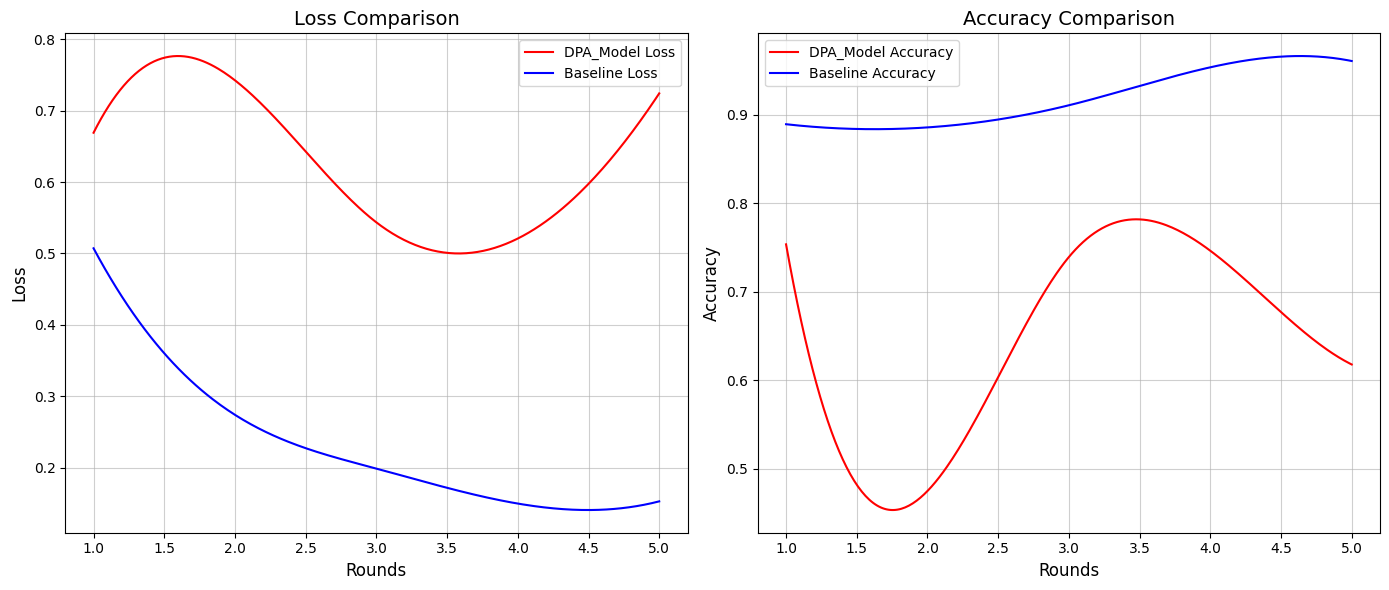

In [81]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# Data for plotting with updated DPA values
rounds = np.arange(1, 6)
dpa_loss = [0.6691, 0.7425, 0.5435, 0.5209, 0.7242]  # Updated from logs
baseline_loss = [0.5072, 0.2739, 0.1986, 0.1496, 0.1527]

dpa_acc = [0.7536, 0.4750, 0.7393, 0.7464, 0.6179]  # Updated from logs
baseline_acc = [0.8893, 0.8857, 0.9107, 0.9536, 0.9607]

# Smooth interpolation
rounds_smooth = np.linspace(rounds.min(), rounds.max(), 300)
dpa_loss_smooth = make_interp_spline(rounds, dpa_loss)(rounds_smooth)
baseline_loss_smooth = make_interp_spline(rounds, baseline_loss)(rounds_smooth)
dpa_acc_smooth = make_interp_spline(rounds, dpa_acc)(rounds_smooth)
baseline_acc_smooth = make_interp_spline(rounds, baseline_acc)(rounds_smooth)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Loss plot
ax[0].plot(rounds_smooth, dpa_loss_smooth, label="DPA_Model Loss", color="red", linestyle="-")
ax[0].plot(rounds_smooth, baseline_loss_smooth, label="Baseline Loss", color="blue", linestyle="-")
ax[0].set_title("Loss Comparison", fontsize=14)
ax[0].set_xlabel("Rounds", fontsize=12)
ax[0].set_ylabel("Loss", fontsize=12)
ax[0].legend()
ax[0].grid(True, linestyle="-", alpha=0.6)

# Accuracy plot
ax[1].plot(rounds_smooth, dpa_acc_smooth, label="DPA_Model Accuracy", color="red", linestyle="-")
ax[1].plot(rounds_smooth, baseline_acc_smooth, label="Baseline Accuracy", color="blue", linestyle="-")
ax[1].set_title("Accuracy Comparison", fontsize=14)
ax[1].set_xlabel("Rounds", fontsize=12)
ax[1].set_ylabel("Accuracy", fontsize=12)
ax[1].legend()
ax[1].grid(True, linestyle="-", alpha=0.6)

plt.tight_layout()
plt.show()